<a href="https://colab.research.google.com/github/imhyunho99/python_vision_with.Prof.Ryu/blob/main/car_logo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c974d88e9b0ffb3bcf32bdf37d0263a1d0c374aedec27998b95aeca4f0ddf095
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import torchvision
import pretrainedmodels

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from tqdm import tqdm
from torchvision.datasets import ImageFolder


def seed_everything(SEED=41):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

SEED=42
seed_everything(SEED=SEED)

In [ ]:
class_list =[
    ['acura',173250000],
    ['alfaromeo',82500000],
    ['buick',59400000],
    ['cadillac',110000000],
    ['dodge',88000000],
    ['fiat',33000000],
    ['opel',44000000]
] 

In [ ]:
dataset_path = "/content/drive/MyDrive/car_logo_proj/data"
train_val_split_ratio = 0.8
learning_rate = 0.0001
num_epoch = 100
batch_size = 8
class_num = 7

trans = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 이미지를 텐서로 변환
])

dataset = ImageFolder(root=dataset_path, transform=trans)

In [ ]:
train_data, test_data = train_test_split(dataset, test_size = 0.2,random_state = 42)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
teat_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

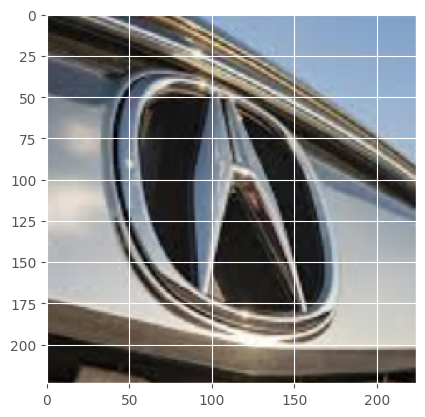

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(dataset[6][0])

In [ ]:
#model

# the resnet34 model
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, class_num)
        self.dropout = nn.Dropout2d(0.6)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResNet34(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


In [ ]:
print(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [ ]:
#train
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor(0.8700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
#test
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)
      output = model.forward(x)
      _,output_index = torch.max(output,1)
      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 100.0


In [ ]:
torch.save(model.state_dict(), 'model')

In [ ]:
import torch
import PIL
# 모델 불러오기
model = ResNet34(pretrained=True).to(device)
model.load_state_dict(torch.load("model"))  #학습한 모델 사용

# 새로운 이미지 로드 및 전처리
image_path = "/content/tester.png"  # 사용할 이미지 파일 업로드 후
image = PIL.Image.open(image_path).convert("RGB")
input_image = trans(image).unsqueeze(0)

if torch.cuda.is_available():
    input_image = input_image.to('cuda')

# 모델 입력 및 예측
output = model(input_image)

# 예측 결과 확인
predicted_label = torch.argmax(output)

print("예측된 라벨:", predicted_label)

FileNotFoundError: ignored

In [ ]:
predicted_label.cpu()
k = predicted_label.item()

In [ ]:
com = class_list[k]

print("이 차량 정보: " ,com[0],"사의 차량으로", "최대",com[1],"원 입니다.")